In [16]:
"""
rasterio
matplotlib
scikit-learn
geopandas
jupyterlab
"""

import rasterio
from rasterio import warp
from rasterio.plot import show
from rasterio.mask import mask
# from rasterio.rio import clip
from matplotlib import pyplot
from rasterio.windows import Window
from affine import Affine
from sklearn.decomposition import PCA
import numpy as np
import geopandas as gpd
import fiona

In [17]:
def trim_raster(data):
    """
    Parameters
    ----------
    data:
        A Rasterio-style numpy array (i.e., bands, rows, columns)
    
    Returns
    ------
    (1) the trimmed data...no nan values
    (2) the masked data array in Rasterio-style
    """
    
    bands, rows, cols = data.shape
    mask = np.isnan(data)
    trimmed = data[~mask]
    mask = np.any(mask, axis=0) 
    trimmed = data[:, ~mask].T
    
    return trimmed, np.invert(mask)

In [18]:
def fill_trimmed_raster(data, mask, bands):
    """
    Parameters
    ----------
    data:
        A trimmed numpy array (i.e., the 'trimmed' output from trim_raster())
        
    mask:
        A mask of the original array (i.e., the 'mask' output from trim_raster())
    
    Returns
    ------
        The original data array in Rasterio-style (and nan's)
    """
    
    rows, cols = mask.shape
    output = np.empty((bands, rows, cols))
    output[:, :, :] = np.nan
    for b in range(bands):
        id = 0
        for r in range(rows):
            for c in range(cols):
                if mask[r, c]==True:
                    output[b, r, c] = data[id, b]
                    id+=1
    
    return output

In [19]:
path = "./data/"

In [20]:
# files = [path + i for i in ['thermal.tif', 'toa8.img']]
files = [path + i for i in ['t1011dc_nowtrS.img', 'toa8.img']]

### This is stuff trying to figure out the alignment of pixels...still needs work

* Compare Affine tranformations of each file

In [12]:
for id, layer in enumerate(files, start=1):
        with rasterio.open(layer) as src:
            print(src.name)
            print(src.transform)
            print()
            print(str(src.width) + ", " + str(src.height))
            print()
            print(src.transform*(src.width, src.height))
            print("\n>>>>>>>>\n")

./data/t1011dc_nowtrS.img
| 30.00, 0.00, 315607.50|
| 0.00,-30.00, 4319347.50|
| 0.00, 0.00, 1.00|

662, 746

(335467.5, 4296967.5)

>>>>>>>>

./data/toa8.img
| 15.00, 0.00, 220792.50|
| 0.00,-15.00, 4426507.50|
| 0.00, 0.00, 1.00|

15661, 15901

(455707.5, 4187992.5)

>>>>>>>>



In [13]:
220785.00 - 220792.50

-7.5

In [14]:
4426515.00 - 4426507.50

7.5

In [15]:
455715.0 - 455707.5- 7.5

0.0

In [16]:
4187985.0 - 4187992.5 + 7.5

0.0

In [17]:
th = rasterio.open(files[0])
pa = rasterio.open(files[1])

In [18]:
th.transform

Affine(30.0, 0.0, 315607.5,
       0.0, -30.0, 4319347.5)

In [19]:
pa.transform

Affine(15.0, 0.0, 220792.5,
       0.0, -15.0, 4426507.5)

In [20]:
new_transform = Affine(pa.transform.a, pa.transform.b, th.transform.c, pa.transform.d, pa.transform.e, th.transform.f)
new_transform

Affine(15.0, 0.0, 315607.5,
       0.0, -15.0, 4319347.5)

In [21]:
new_transform*(pa.width, pa.height)

(550522.5, 4080832.5)

In [22]:
th.transform*(th.width, th.height)

(335467.5, 4296967.5)

In [23]:
new_transform.a

15.0

In [24]:
pa.width / new_transform.a

1044.0666666666666

In [25]:
pa.width

15661

In [26]:
pa.width / 2

7830.5

### End of alignment stuff (which needs work)

## 1. Read a windowed version of the thermal image (the window may be for the whole image)

In [47]:
# with rasterio.open(files[0]) as thermal_src:
#     thermal = thermal_src.read(window=Window(0, 0, thermal_src.width, thermal_src.height))
#     print("Shape: " + str(thermal_src.shape))
#     print("Bands: " + str(thermal_src.count))
#     print("Width: " + str(thermal_src.width) + ", Height: " + str(thermal_src.height))
#     print("Transform: ")
#     print(thermal_src.transform)

In [48]:
shape_src = gpd.read_file("./data/dc_sans_water.geojson")
type(shape_src)

geopandas.geodataframe.GeoDataFrame

In [49]:
shape_src.geometry

0    (POLYGON ((316304.969009929 4311666.374814316,...
Name: geometry, dtype: object

In [50]:
raster_src = rasterio.open(files[0])

In [51]:
out_image, out_transform = mask(raster_src, shape_src.geometry, crop=True)

In [52]:
out_transform

Affine(30.0, 0.0, 316237.5,
       0.0, -30.0, 4318327.5)

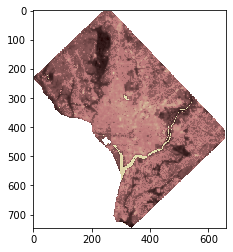

In [53]:
thermal = raster_src.read(1)
thermal[thermal==0]= np.nan
pyplot.imshow(thermal, cmap='pink')
pyplot.show()

In [33]:

# with fiona.open(f, "r") as shape_src:
with gpd.read_file("./data/dc_sans_water.geojson") as shape_src:
    shapes = [feature["geometry"] for feature in shape_src]
    with rasterio.open(files[0]) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta

AttributeError: __enter__

In [30]:
out_transform

Affine(30.0, 0.0, 316237.5,
       0.0, -30.0, 4318327.5)

In [28]:
thermal.shape

(2, 746, 662)

In [29]:
thermal_src.crs

CRS.from_epsg(32618)

In [30]:
thermal

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [11]:
thermal[thermal.shape[0] // 2, thermal.shape[1] // 2, thermal.shape[2] // 2]

300.06356432944744

In [12]:
thermal[thermal==0]= np.nan
thermal

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

In [13]:
thermal[thermal.shape[0] // 2, thermal.shape[1] // 2, thermal.shape[2] // 2]

300.06356432944744

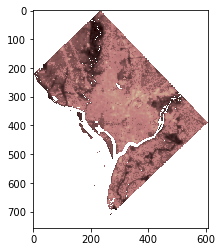

In [14]:
pyplot.imshow(thermal[0], cmap='pink')
pyplot.show()

/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


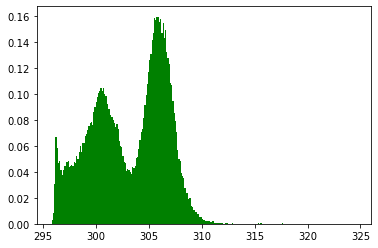

In [41]:
n, bins, patches = pyplot.hist(thermal[0].flatten(), 250, density=True, facecolor='g')
# pyplot.xlim(285, 325)
pyplot.show()

## 2. Clip to city boundary and rasterize water pixels to nan's

In [200]:
city = gpd.read_file("./data/misc_proj/Washington_DC_Boundary.shp")

In [201]:
city

,OBJECTID,CITY_NAME,STATE_CITY,CAPITAL,WEB_URL,AREAKM,AREAMILES,Shape_Leng,Shape_Area,geometry
0,1,Washington,1150000,Y,http://www.dc.gov,177.47,68.52,67608.276922,1.774562e+08,"POLYGON ((-77.1197952245159 38.93435090401753,..."


In [202]:
city.crs

{'init': 'epsg:4326'}

In [203]:
dc = city.to_crs({"init": "epsg:32618"})

In [204]:
dc.to_file("./data/dc.shp")

In [205]:
waterbodies = gpd.read_file("./data/misc_proj/Waterbodies.shp")

In [206]:
waterbodies

,geometry
0,POLYGON ((-76.94461882195716 38.91305813040341...
1,POLYGON ((-76.97789200869727 38.90795756129859...
2,POLYGON ((-76.94295265037282 38.91229983993424...
3,POLYGON ((-76.97070620954447 38.91140178250719...
4,POLYGON ((-76.94425547039874 38.91233227887311...
...,...
1191,POLYGON ((-77.02389279324775 38.81517569131125...
1192,"POLYGON ((-77.0238132417558 38.81526002701816,..."
1193,"POLYGON ((-77.0237221639934 38.8153529168835, ..."
1194,POLYGON ((-77.02364172009629 38.81543837308315...


In [207]:
waterbodies.crs

{'init': 'epsg:4269'}

In [208]:
water = waterbodies.to_crs({"init": "epsg:32618"})

In [209]:
water.to_file("./data/water.shp")

## 3. Trim away the nan's

In [42]:
trimmed, mask = trim_raster(thermal)

In [43]:
trimmed

array([[301.66171543, 295.1754946 ],
       [300.95206451, 294.70040082],
       [300.82150673, 294.40351838],
       ...,
       [298.21064671, 293.09238875],
       [295.81241936, 290.73836669],
       [298.20425266, 293.17417017]])

In [44]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [45]:
np.min(trimmed[:, 0])

295.80312434709884

In [46]:
np.max(trimmed[:, 0])

324.6010471815678

In [47]:
trimmed.shape

(176176, 2)

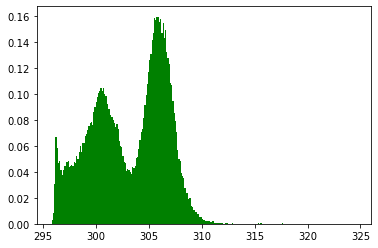

In [48]:
n, bins, patches = pyplot.hist(trimmed[:, 0], 250, density=True, facecolor='g')
# pyplot.xlim(285, 325)
pyplot.show()

In [51]:
print(np.min(trimmed[:, 1]))
print(np.max(trimmed[:, 1]))

290.7383666857898
317.48030348151605


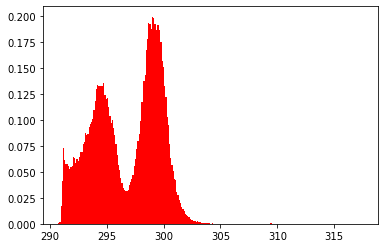

In [49]:
n, bins, patches = pyplot.hist(trimmed[:, 1], 250, density=True, facecolor='r')
# pyplot.xlim(285, 325)
pyplot.show()

## 3. Perform Principal Components Analysis

In [20]:
pca = PCA(n_components=2)

In [21]:
pc = pca.fit_transform(trimmed)

In [22]:
print(pca.explained_variance_ratio_) 

[0.99825886 0.00174114]


In [23]:
print(pca.explained_variance_) 

[20.53409084  0.03581516]


In [24]:
print(pca.components_)

[[ 0.76937504  0.63879735]
 [-0.63879735  0.76937504]]


In [25]:
pc.shape

(176176, 2)

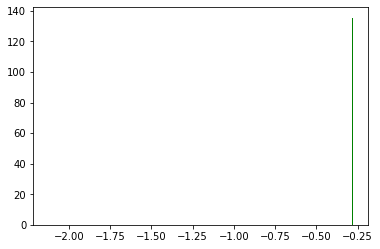

In [26]:
n, bins, patches = pyplot.hist(pc[0].flatten(), 500, density=True, facecolor='g')
# pyplot.xlim(-0.2, 0)
pyplot.show()

In [27]:
pc

array([[-2.12368051, -0.27832864],
       [-2.97315685, -0.19053081],
       [-3.26325247, -0.33554479],
       ...,
       [-6.10952913,  0.32351527],
       [-9.45840844,  0.04437074],
       [-6.06220679,  0.39052036]])

## 4. Scale panchromatic band to the thermal range and 

## 5. Map back to band, row, column

In [28]:
pc = fill_trimmed_raster(trimmed, mask, thermal.shape[0])

In [29]:
pc[pc.shape[0] // 2, pc.shape[1] // 2, pc.shape[2] // 2]

300.06356432944744

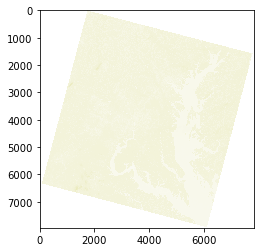

In [92]:
pyplot.imshow(pc[0], cmap='pink')
pyplot.show()

In [ ]:
a = thermal.flatten()
n, bins, patches = pyplot.hist(a, 250, density=True, facecolor='g')
pyplot.xlim(250, np.nanmax(a))
pyplot.show()